# Drowsiness Detection using eyes only (Awake and Drowsy State)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from skimage import feature, exposure, filters, img_as_ubyte
from sklearn.metrics import accuracy_score
import h5py
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model

# Data loading

In [2]:
dataset_directory = r"C:\Users\HP\OneDrive\FINAL DROWSY\Code\final\V5dataset"
classes = ["Closed_Eyes", "Open_Eyes"]
img_size = 224

# compute and save normalization parameters

In [3]:
# Function to compute and save normalization parameters
def compute_and_save_normalization_params(train_data):
    scaler = StandardScaler()
    scaler.fit(train_data)
    np.savez("normalization_params_drowsy.npz", mean=scaler.mean_, std=scaler.scale_)

In [4]:
# Function to load normalization parameters during inference
def load_normalization_params():
    normalization_params = np.load("normalization_params_drowsy.npz")
    mean = normalization_params['mean']
    std = normalization_params['std']
    return mean, std

In [5]:
# Function to load and preprocess data
def load_and_preprocess_data(directory, classes, img_size):
    data = []
    labels = []

    for class_label, category in enumerate(classes):
        path = os.path.join(directory, category)

        for img in os.listdir(path):
            img_path = os.path.join(path, img)

            # Read the image
            img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
            img_array = cv2.resize(img_array, (img_size, img_size))

            # Stack the image to the data
            data.append(img_array)
            labels.append(class_label)

    data = np.array(data)
    labels = np.array(labels)

    return data, labels

# Load and preprocess data
data, labels = load_and_preprocess_data(dataset_directory, classes, img_size)


# Data splitting and saving

In [6]:
# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
# Perform normalization only on the training data
scaler = StandardScaler()
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
scaler.fit(X_train_flattened)

# Transform all sets using the same scaler
X_train_scaled = scaler.transform(X_train_flattened).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(X_val.shape[0], -1)).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

# Stack grayscale images along a new axis to mimic 3 channels
X_train_stacked = np.stack([X_train_scaled] * 3, axis=-1)
X_val_stacked = np.stack([X_val_scaled] * 3, axis=-1)
X_test_stacked = np.stack([X_test_scaled] * 3, axis=-1)

# Preprocess input data
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

X_train_preprocessed = preprocess_input(X_train_stacked)
X_val_preprocessed = preprocess_input(X_val_stacked)
X_test_preprocessed = preprocess_input(X_test_stacked)

In [8]:
print(X_train_preprocessed.shape)
print(X_val_preprocessed .shape)
print(X_test_preprocessed.shape)

(6592, 224, 224, 3)
(1413, 224, 224, 3)
(1413, 224, 224, 3)


In [9]:
# Print the length of each split dataset
print(f"Length of Training Set: {len(X_train)}")
print(f"Length of Validation Set: {len(X_val)}")
print(f"Length of Test Set: {len(X_test)}")

Length of Training Set: 6592
Length of Validation Set: 1413
Length of Test Set: 1413


In [10]:
# Calculate ratios
total_length = len(X_train) + len(X_val) + len(X_test)
train_ratio = len(X_train) / total_length
val_ratio = len(X_val) / total_length
test_ratio = len(X_test) / total_length

# Print ratios
print(f"Ratio of Training Set: {train_ratio * 100:.2f}%")
print(f"Ratio of Validation Set: {val_ratio * 100:.2f}%")
print(f"Ratio of Test Set: {test_ratio * 100:.2f}%")

Ratio of Training Set: 69.99%
Ratio of Validation Set: 15.00%
Ratio of Test Set: 15.00%


In [12]:
# Set input shape and batch size
input_shape = (224, 224, 3)
batch_size = 32
num_epochs = 50

# Model Development

In [13]:
from keras import regularizers

def build_model_l2(input_shape, l2_penalty=0.01):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    for layer in base_model.layers:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.LayerNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_penalty)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  
    ])

    return model


In [14]:
print("Shape of training labels:", y_train.shape)
print("Shape of validation labels:", y_val.shape)

Shape of training labels: (6592,)
Shape of validation labels: (1413,)


In [15]:
# Reshape the training and validation labels
y_train_reshaped = y_train.reshape(-1, 1)
y_val_reshaped = y_val.reshape(-1, 1)

print("Shape of training labels (after reshaping):", y_train_reshaped.shape)
print("Shape of validation labels (after reshaping):", y_val_reshaped.shape)

Shape of training labels (after reshaping): (6592, 1)
Shape of validation labels (after reshaping): (1413, 1)


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_batch_size = 32
val_batch_size = 32

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2),
)

# Apply the same normalization as performed during training
X_val_scaled = X_val_preprocessed / 255.0

train_generator = train_datagen.flow(
    X_train_preprocessed,
    y_train_reshaped,  
    batch_size=train_batch_size,
    shuffle=True,
    seed=42
)

# Validation set without augmentation
validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow(
    X_val_preprocessed,
    y_val_reshaped,  
    batch_size=val_batch_size,
    shuffle=False
)

In [17]:
# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Model Compilation

In [18]:
# Compile the model and include the learning rate scheduler in the callbacks list
model = build_model_l2(input_shape)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# Set up ModelCheckpoint to save the best model during training
checkpoint = ModelCheckpoint("drowsy_best_model.keras", monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Model Before Training

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ ?                           │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ ?                           │     0 (unbuilt) │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

# Model Training

In [32]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train_preprocessed) // train_batch_size,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=len(X_val_preprocessed) // val_batch_size,
    callbacks=[lr_scheduler]
)

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.6915 - loss: 0.6197 - val_accuracy: 0.7472 - val_loss: 0.5793 - learning_rate: 0.0010
Epoch 2/50


C:\Users\HP\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.4894 - learning_rate: 0.0010
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.7004 - loss: 0.6087 - val_accuracy: 0.7678 - val_loss: 0.5439 - learning_rate: 0.0010
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.4594 - learning_rate: 0.0010
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.7142 - loss: 0.5949 - val_accuracy: 0.7607 - val_loss: 0.5870 - learning_rate: 0.0010
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8000 - val_loss: 0.6849 - learning_rate: 0.0010
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.7191 - loss: 0.5879 - val_accuracy: 0.7770 - val_loss: 0.5530 - learning_rate: 0.0010
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+

In [36]:
model.save('DROWSY_model.keras')

In [37]:
drowsy_model = tf.keras.models.load_model("DROWSY_model.keras")

In [38]:
drowsy_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 7, 7, 1280)     │         2,560 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,757,957 (10.52 MB)

 Trainable params: 166,657 (651.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 333,316 (1.27 MB)

In [33]:
model.save('drowsy_best_model.keras')

In [34]:
best_model = tf.keras.models.load_model('drowsy_best_model.keras')

In [35]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 7, 7, 1280)     │         2,560 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,757,957 (10.52 MB)

 Trainable params: 166,657 (651.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 333,316 (1.27 MB)

# Predictions and Evaluation Metrices

In [29]:
# Step 1: Make predictions
y_pred = drowsy_model.predict(X_val_preprocessed) 

# Step 2: Convert predictions to binary values
y_pred_binary = (y_pred > 0.5).astype(int)  

# Step 3: Calculate confusion matrix
conf_matrix = confusion_matrix(y_val_reshaped, y_pred_binary)

45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 823ms/step


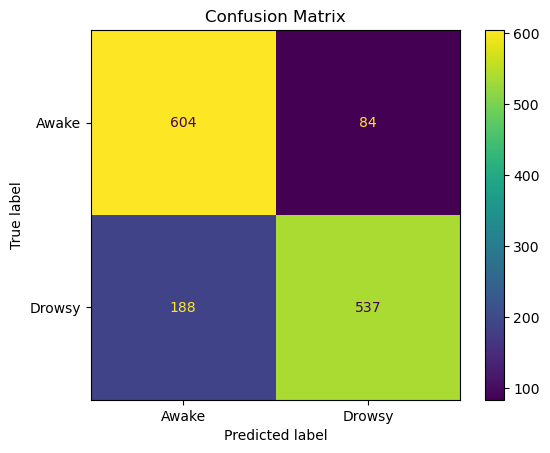

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Awake", "Drowsy"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [31]:
# Print classification report 
print("Classification Report:")
print(classification_report(y_val_reshaped, y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.88      0.82       688
           1       0.86      0.74      0.80       725

    accuracy                           0.81      1413
   macro avg       0.81      0.81      0.81      1413
weighted avg       0.82      0.81      0.81      1413



In [32]:
accuracy = accuracy_score(y_val_reshaped, y_pred_binary)
print("Accuracy:", accuracy)

Accuracy: 0.8075017692852088


# Evaluate the model using ImageDataGenerator

In [33]:
# Evaluate the model using ImageDataGenerator on training data
train_loss, train_accuracy = drowsy_model.evaluate(train_generator, steps=len(X_train_preprocessed) // batch_size)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate the model using ImageDataGenerator on validation data
val_loss, val_accuracy = drowsy_model.evaluate(validation_generator, steps=len(X_val_preprocessed) // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

206/206 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.7854 - loss: 0.5137
Training Accuracy: 78.99%
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 842ms/step - accuracy: 0.8030 - loss: 0.5028
Validation Accuracy: 80.68%


In [34]:
print("Shape of validation labels:", y_test.shape)

Shape of validation labels: (1413,)


In [35]:
y_test_reshaped = y_val.reshape(-1, 1)
print("Shape of validation labels:", y_test_reshaped.shape)

Shape of validation labels: (1413, 1)


# Best Model Evaluation Metrices

In [39]:
# Step 1: Make predictions
y_pred = best_model.predict(X_val_preprocessed) 

# Step 2: Convert predictions to binary values
y_pred_binary = (y_pred > 0.5).astype(int)  

# Step 3: Calculate confusion matrix
conf_matrix = confusion_matrix(y_val_reshaped, y_pred_binary)

45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 784ms/step


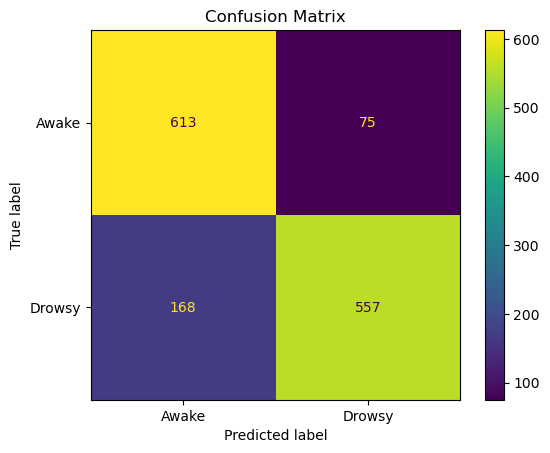

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Awake", "Drowsy"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [41]:
# Print classification report 
print("Classification Report:")
print(classification_report(y_val_reshaped, y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       688
           1       0.88      0.77      0.82       725

    accuracy                           0.83      1413
   macro avg       0.83      0.83      0.83      1413
weighted avg       0.83      0.83      0.83      1413



In [42]:
accuracy = accuracy_score(y_val_reshaped, y_pred_binary)
print("Accuracy:", accuracy)

Accuracy: 0.8280254777070064


In [43]:
# Evaluate the model using ImageDataGenerator on training data
train_loss, train_accuracy = best_model.evaluate(train_generator, steps=len(X_train_preprocessed) // batch_size)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate the model using ImageDataGenerator on validation data
val_loss, val_accuracy = best_model.evaluate(validation_generator, steps=len(X_val_preprocessed) // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

206/206 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.8091 - loss: 0.4779
Training Accuracy: 80.90%
44/44 ━━━━━━━━━━━━━━━━━━━━ 35s 784ms/step - accuracy: 0.8227 - loss: 0.4629
Validation Accuracy: 82.74%


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_batch_size = 32 

test_generator = test_datagen.flow(
    X_test_preprocessed ,
    y_test,
    batch_size=test_batch_size,
    shuffle=False
)

# Evaluate the model using ImageDataGenerator on test data
test_loss, test_accuracy = best_model.evaluate(test_generator, steps=len(X_test_preprocessed) // test_batch_size)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


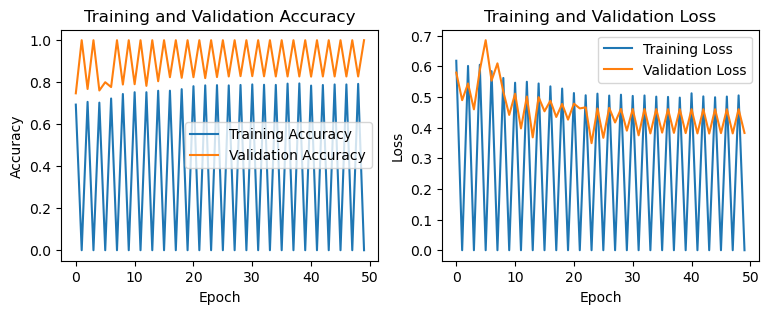

In [45]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(9, 3))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot training history
plot_training_history(history)


# Real Time Inferencing

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import time

# Paths to Haar cascade classifiers
face_cascade_path = r"C:\Users\HP\OneDrive\FINAL DROWSY\Code\Requirement files\haarcascade_frontalface_default.xml"
eye_cascade_path = r"C:\Users\HP\OneDrive\FINAL DROWSY\Code\Requirement files\haarcascade_eye.xml"

# Load Haar cascades
faceCascade = cv2.CascadeClassifier(face_cascade_path)
eyeCascade = cv2.CascadeClassifier(eye_cascade_path)

# Initialize the video capture object
cap = cv2.VideoCapture(0)

# Check if the webcam is opened successfully
if not cap.isOpened():
    print('Error: Cannot open webcam')
    exit()

# Paths to the pre-trained model and Haar cascade classifiers
saved_model_path = r"C:\Users\HP\OneDrive\FINAL DROWSY\Code\final\DROWSY_model.keras"

# Loading the saved Keras model
loaded_model = load_model(saved_model_path)

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Parameters for drowsiness detection
DROWSINESS_THRESHOLD_SECONDS = 1

# Initialize variables to track eye closure
closed_eyes_start_time = None
closed_eyes_duration = 0
closed_eyes_duration_display = 0

try:
    while True:
        ret, frame = cap.read()

        if not ret:
            print('Error: Cannot read frame')
            break

        frame = cv2.resize(frame, (640, 480))

        # Convert the frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the grayscale frame
        faces = faceCascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Display the number of faces detected
        num_faces = len(faces)  # Get the number of detected faces
        cv2.putText(frame, f"Faces Detected: {num_faces}", (20, 450), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

        eye_status = "Awake"
        elapsed_time = 0

        # Process each detected face
        for (fx, fy, fw, fh) in faces:
            # Extract the face region from the frame
            roi_gray = gray[fy:fy + fh, fx:fx + fw]
            roi_color = frame[fy:fy + fh, fx:fx + fw]

            # Detect eyes within the face region
            eyes = eyeCascade.detectMultiScale(roi_gray)

            if len(eyes) == 0:
                # No eyes detected
                if closed_eyes_start_time is None:
                    closed_eyes_start_time = time.time()
                else:
                    elapsed_time = time.time() - closed_eyes_start_time
                    if elapsed_time >= DROWSINESS_THRESHOLD_SECONDS:
                        eye_status = "Drowsy"
            else:
                if closed_eyes_start_time is not None:
                    closed_eyes_duration = time.time() - closed_eyes_start_time
                    closed_eyes_duration_display = closed_eyes_duration
                closed_eyes_start_time = None

            # Process each detected eye
            for (ex, ey, ew, eh) in eyes:
                # Extract the eye region from the face
                eye_roi = roi_color[ey:ey + eh, ex:ex + ew]

                # Preprocess the eye region
                eye_roi_gray = cv2.equalizeHist(cv2.cvtColor(eye_roi, cv2.COLOR_BGR2GRAY))
                eye_roi_gray = cv2.GaussianBlur(eye_roi_gray, (5, 5), 0)

                # Resize and normalize the eye region to match the input size of the model (224x224)
                final_eye_image = cv2.resize(eye_roi_gray, (224, 224))
                final_eye_image_rgb = cv2.cvtColor(final_eye_image, cv2.COLOR_GRAY2RGB)  # Convert to RGB
                final_eye_image_rgb = final_eye_image_rgb.astype(np.float32) / 255.0  # Normalize pixel values
                final_eye_image_rgb = np.expand_dims(final_eye_image_rgb, axis=0)  # Add batch dimension

                # Make predictions using the model
                prediction = loaded_model.predict(final_eye_image_rgb)
                threshold = 0.5
                status = "Awake" if prediction[0][0] > threshold else "Drowsy"

                # Append true and predicted labels
                true_labels.append(1)  # Placeholder for true label
                predicted_labels.append(1 if status == "Awake" else 0)

                # Display the status on the frame
                font = cv2.FONT_HERSHEY_PLAIN
                cv2.putText(frame, status, (fx + 20, fy - 20), font, 3, (0, 255, 0), 2, cv2.LINE_AA)

        # Display additional drowsiness duration message if applicable
        if closed_eyes_duration_display > 0:
            cv2.putText(frame, f"Drowsy for {closed_eyes_duration_display:.2f} seconds", (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        cv2.imshow('Drowsiness Detector', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

finally:
    cap.release()
    cv2.destroyAllWindows()


# THE FINAL BEEP 

In [ ]:
# alert 
import cv2
import time
import numpy as np
from tensorflow.keras.models import load_model
import winsound  # Import winsound for playing beep sound

# Paths to Haar cascade classifiers
face_cascade_path = r"C:\Users\HP\OneDrive\FINAL DROWSY\Code\Requirement files\haarcascade_frontalface_default.xml"
eye_cascade_path = r"C:\Users\HP\OneDrive\FINAL DROWSY\Code\Requirement files\haarcascade_eye.xml"

# Load Haar cascades
face_cascade = cv2.CascadeClassifier(face_cascade_path)
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

# Load the pre-trained Keras model
saved_model_path = r"C:\Users\HP\OneDrive\FINAL DROWSY\Code\final\DROWSY_model.keras"
loaded_model = load_model(saved_model_path)

# Initialize the video capture object
cap = cv2.VideoCapture(0)

# Check if the webcam is opened successfully
if not cap.isOpened():
    print('Error: Cannot open webcam')
    exit()

# Parameters for drowsiness detection
DROWSINESS_THRESHOLD_SECONDS = 1

# Initialize variables to track eye closure
closed_eyes_start_time = None
closed_eyes_duration = 0
closed_eyes_duration_display = 0

# Function to play beep sound
def play_beep():
    winsound.Beep(1000, 200)  # Frequency = 1000Hz, Duration = 200ms

try:
    while True:
        ret, frame = cap.read()

        if not ret:
            print('Error: Cannot read frame')
            break

        frame = cv2.resize(frame, (640, 480))

        # Convert the frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the grayscale frame
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        num_faces = len(faces)
        cv2.putText(frame, f"Faces Detected: {num_faces}", (20, 450), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
        eye_status = "Awake"
        elapsed_time = 0

        # Process each detected face
        for (fx, fy, fw, fh) in faces:
            # Extract the face region from the frame
            roi_gray = gray[fy:fy + fh, fx:fx + fw]

            # Detect eyes within the face region
            eyes = eye_cascade.detectMultiScale(roi_gray)

            # Process each detected eye
            for (ex, ey, ew, eh) in eyes:
                # Extract the eye region from the face
                eye_roi_gray = roi_gray[ey:ey + eh, ex:ex + ew]

                # Preprocess the eye region
                eye_roi_gray = cv2.equalizeHist(eye_roi_gray)
                eye_roi_gray = cv2.GaussianBlur(eye_roi_gray, (5, 5), 0)

                # Resize and normalize the eye region to match the input size of the model (224x224)
                final_eye_image = cv2.resize(eye_roi_gray, (224, 224))
                final_eye_image_rgb = cv2.cvtColor(final_eye_image, cv2.COLOR_GRAY2RGB)
                final_eye_image_rgb = final_eye_image_rgb.astype(np.float32) / 255.0
                final_eye_image_rgb = np.expand_dims(final_eye_image_rgb, axis=0)

                # Make predictions using the loaded model
                prediction = loaded_model.predict(final_eye_image_rgb)
                threshold = 0.5
                status = "Awake" if prediction[0][0] > threshold else "Drowsy"

                # Update eye status and elapsed time
                if status == "Drowsy":
                    if closed_eyes_start_time is None:
                        closed_eyes_start_time = time.time()
                    else:
                        elapsed_time = time.time() - closed_eyes_start_time
                        if elapsed_time >= DROWSINESS_THRESHOLD_SECONDS:
                            eye_status = "Drowsy"
                            # Play beep sound when drowsiness threshold is surpassed
                            play_beep()
                else:
                    if closed_eyes_start_time is not None:
                        closed_eyes_duration = time.time() - closed_eyes_start_time
                        closed_eyes_duration_display = closed_eyes_duration
                    closed_eyes_start_time = None

        # Display the status on the frame
        font = cv2.FONT_HERSHEY_SIMPLEX
        if eye_status == "Drowsy":
            cv2.putText(frame, f"Asleep for {elapsed_time:.2f} seconds", (20, 40), font, 1, (0, 0, 255), 2, cv2.LINE_AA)
        else:
            if closed_eyes_start_time is not None:
                elapsed_time = time.time() - closed_eyes_start_time
                cv2.putText(frame, f"Drowsy for  {elapsed_time:.2f} seconds", (20, 40), font, 1, (0, 255, 255), 2, cv2.LINE_AA)
            else:
                if closed_eyes_duration_display > 0:
                    cv2.putText(frame, f"Drowsy for {closed_eyes_duration_display:.2f} seconds", (20, 40), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
                else:
                    cv2.putText(frame, eye_status, (20, 40), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

        cv2.imshow('Drowsiness Detector', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

finally:
    cap.release()
    cv2.destroyAllWindows()


In [5]:
import cv2
import time
import numpy as np
from tensorflow.keras.models import load_model
import pyttsx3  # Import the text-to-speech library

# Paths to Haar cascade classifiers
face_cascade_path = r"C:\Users\HP\OneDrive\FINAL DROWSY\Code\Requirement files\haarcascade_frontalface_default.xml"
eye_cascade_path = r"C:\Users\HP\OneDrive\FINAL DROWSY\Code\Requirement files\haarcascade_eye.xml"

# Load Haar cascades
face_cascade = cv2.CascadeClassifier(face_cascade_path)
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

# Load the pre-trained Keras model
saved_model_path = r"C:\Users\HP\OneDrive\FINAL DROWSY\Code\final\DROWSY_model.keras"
loaded_model = load_model(saved_model_path)

# Initialize the video capture object
cap = cv2.VideoCapture(1)

# Check if the webcam is opened successfully
if not cap.isOpened():
    print('Error: Cannot open webcam')
    exit()

# Initialize the TTS engine
engine = pyttsx3.init()

# Parameters for drowsiness detection
DROWSINESS_THRESHOLD_SECONDS = 3

# Initialize variables to track eye closure
closed_eyes_start_time = None
closed_eyes_duration = 0
closed_eyes_duration_display = 0
alert_played = False

try:
    while True:
        ret, frame = cap.read()

        if not ret:
            print('Error: Cannot read frame')
            break

        frame = cv2.resize(frame, (640, 480))

        # Convert the frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the grayscale frame
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        num_faces = len(faces)
        cv2.putText(frame, f"Faces Detected: {num_faces}", (20, 450), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
        eye_status = "Awake"
        elapsed_time = 0

        # Process each detected face
        for (fx, fy, fw, fh) in faces:
            # Extract the face region from the frame
            roi_gray = gray[fy:fy + fh, fx:fx + fw]

            # Detect eyes within the face region
            eyes = eye_cascade.detectMultiScale(roi_gray)

            # Process each detected eye
            for (ex, ey, ew, eh) in eyes:
                # Extract the eye region from the face
                eye_roi_gray = roi_gray[ey:ey + eh, ex:ex + ew]

                # Preprocess the eye region
                eye_roi_gray = cv2.equalizeHist(eye_roi_gray)
                eye_roi_gray = cv2.GaussianBlur(eye_roi_gray, (5, 5), 0)

                # Resize and normalize the eye region to match the input size of the model (224x224)
                final_eye_image = cv2.resize(eye_roi_gray, (224, 224))
                final_eye_image_rgb = cv2.cvtColor(final_eye_image, cv2.COLOR_GRAY2RGB)
                final_eye_image_rgb = final_eye_image_rgb.astype(np.float32) / 255.0
                final_eye_image_rgb = np.expand_dims(final_eye_image_rgb, axis=0)

                # Make predictions using the loaded model
                prediction = loaded_model.predict(final_eye_image_rgb)
                threshold = 0.5
                status = "Awake" if prediction[0][0] > threshold else "Drowsy"

                # Update eye status and elapsed time
                if status == "Drowsy":
                    if closed_eyes_start_time is None:
                        closed_eyes_start_time = time.monotonic()
                        alert_played = False  # Reset alert flag
                    else:
                        elapsed_time = time.monotonic() - closed_eyes_start_time
                        if elapsed_time >= DROWSINESS_THRESHOLD_SECONDS:
                            eye_status = "Drowsy"
                            if not alert_played:
                                # Play the alert sound
                                engine.say("Warning! Asleep for over 5 seconds.")
                                engine.runAndWait()
                                alert_played = True
                else:
                    if closed_eyes_start_time is not None:
                        closed_eyes_duration = time.monotonic() - closed_eyes_start_time
                        closed_eyes_duration_display = closed_eyes_duration
                    closed_eyes_start_time = None
                    alert_played = False  # Reset alert flag when eyes are open

        # Display the status on the frame
        font = cv2.FONT_HERSHEY_SIMPLEX
        if eye_status == "Drowsy":
            cv2.putText(frame, f"Asleep for {elapsed_time:.2f} seconds", (100, 50), font, 1, (0, 0, 255), 2, cv2.LINE_AA)
        else:
            if closed_eyes_start_time is not None:
                elapsed_time = time.monotonic() - closed_eyes_start_time
                cv2.putText(frame, f"Drowsy for {elapsed_time:.2f} seconds", (20, 40), font, 1, (0, 255, 255), 2, cv2.LINE_AA)
            else:
                if closed_eyes_duration_display > 0:
                    cv2.putText(frame, f"Asleep for {closed_eyes_duration_display:.2f} seconds", (20, 40), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
                else:
                    cv2.putText(frame, eye_status, (20, 40), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

        cv2.imshow('Drowsiness Detector', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

finally:
    cap.release()
    cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━

# Predictions and Evaluations

In [5]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

NameError: name 'true_labels' is not defined

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

In [ ]:
# Display the true and predicted labels
print("True Labels:", true_labels)
print("Predicted Labels:", predicted_labels)

In [ ]:
# Convert lists to numpy arrays 
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)